In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

**Downloading Latest COVID-19 Data From John Hopkins University Directory**

In [2]:
%%time
import requests

for filename in ['time_series_covid19_confirmed_global.csv',
                 'time_series_covid19_deaths_global.csv',
                 'time_series_covid19_recovered_global.csv',
                 ]:
    print(f'Downloading {filename}')
    url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/{filename}'
    myfile = requests.get(url)
    open(filename, 'wb').write(myfile.content)

CPU times: user 63.6 ms, sys: 9.49 ms, total: 73.1 ms
Wall time: 375 ms


**Removing unnessecary columns and converting dates into datetime format**

In [3]:
from datetime import datetime

def _convert_date_str(df):
    try:
        df.columns = list(df.columns[:4]) + [datetime.strptime(d, "%m/%d/%y").date().strftime("%Y-%m-%d") for d in df.columns[4:]]
    except:
        print('_convert_date_str failed with %y, try %Y')
        df.columns = list(df.columns[:4]) + [datetime.strptime(d, "%m/%d/%Y").date().strftime("%Y-%m-%d") for d in df.columns[4:]]


confirmed_global_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
_convert_date_str(confirmed_global_df)

deaths_global_df = pd.read_csv('time_series_covid19_deaths_global.csv')
_convert_date_str(deaths_global_df)

recovered_global_df = pd.read_csv('time_series_covid19_recovered_global.csv')
_convert_date_str(recovered_global_df)

**Filtering out problematic data points**

In [4]:
# Filter out problematic data points (The West Bank and Gaza had a negative value, cruise ships were associated with Canada, etc.)
removed_states = "Recovered|Grand Princess|Diamond Princess"
removed_countries = "US|The West Bank and Gaza"

confirmed_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)
deaths_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)
recovered_global_df.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace=True)

confirmed_global_df = confirmed_global_df[~confirmed_global_df["Province_State"].replace(np.nan, "nan").str.match(removed_states)]
deaths_global_df    = deaths_global_df[~deaths_global_df["Province_State"].replace(np.nan, "nan").str.match(removed_states)]
recovered_global_df = recovered_global_df[~recovered_global_df["Province_State"].replace(np.nan, "nan").str.match(removed_states)]

confirmed_global_df = confirmed_global_df[~confirmed_global_df["Country_Region"].replace(np.nan, "nan").str.match(removed_countries)]
deaths_global_df    = deaths_global_df[~deaths_global_df["Country_Region"].replace(np.nan, "nan").str.match(removed_countries)]
recovered_global_df = recovered_global_df[~recovered_global_df["Country_Region"].replace(np.nan, "nan").str.match(removed_countries)]

In [5]:
confirmed_global_melt_df = confirmed_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='ConfirmedCases')
deaths_global_melt_df = deaths_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='Deaths')
recovered_global_melt_df = deaths_global_df.melt(
    id_vars=['Country_Region', 'Province_State', 'Lat', 'Long'], value_vars=confirmed_global_df.columns[4:], var_name='Date', value_name='Recovered')

**Merging confirmed, deaths and recovered datasets**

In [6]:
train = confirmed_global_melt_df.merge(deaths_global_melt_df, on=['Country_Region', 'Province_State', 'Lat', 'Long', 'Date'])
train = train.merge(recovered_global_melt_df, on=['Country_Region', 'Province_State', 'Lat', 'Long', 'Date'])

**Removing rows with empty values and renaming columns**

In [7]:
train.rename({'Country_Region': 'country', 'Province_State': 'province', 'Id': 'id', 'Date': 'date', 'ConfirmedCases': 'confirmed', 'Deaths': 'fatalities', 'Recovered': 'recovered'}, axis=1, inplace=True)
train['country_province'] = train['country'].fillna('') + '/' + train['province'].fillna('')

**Filtering European Countries**

In [8]:
europe_country_list =list([
    'Austria','Belgium','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland',
    'Italy', 'Latvia','Luxembourg','Lithuania','Malta','Norway','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia',
    'Spain', 'Sweden', 'United Kingdom', 'Iceland', 'Russia', 'Switzerland', 'Serbia', 'Ukraine', 'Belarus',
    'Albania', 'Bosnia and Herzegovina', 'Kosovo', 'Moldova', 'Montenegro', 'North Macedonia'])

In [9]:
train = train[train['country'].isin(europe_country_list)]


**Grouping the data by date by summing the particular rows**

In [10]:
train = train.groupby(['date', 'country']).sum()

In [11]:
train = train.drop(['Lat', 'Long'], axis = 1)
train.reset_index(inplace=True)


**Downloading latest mobility data from google**

In [12]:
df = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning:

Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.



In [13]:
europe_country_list =list([
    'Austria','Belgium','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland',
    'Italy', 'Latvia','Luxembourg','Lithuania','Malta','Norway','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia',
    'Spain', 'Sweden', 'United Kingdom', 'Iceland', 'Russia', 'Switzerland', 'Serbia', 'Ukraine', 'Belarus',
    'Albania', 'Bosnia and Herzegovina', 'Kosovo', 'Moldova', 'Montenegro', 'North Macedonia'])

In [14]:
df = df[df['country_region'].isin(europe_country_list)]
df.shape

(1381991, 15)

**Removing unnecessary columns**

In [15]:
df = df.drop(['sub_region_1', 'sub_region_2', 'country_region_code', 'sub_region_2', 'metro_area',
              'iso_3166_2_code', 'census_fips_code', 'place_id'], axis = 1)

In [16]:
df = df.groupby(['date', 'country_region']).sum()

In [17]:
df.reset_index(inplace=True)


In [18]:
vaccination = pd.read_csv('../input/covid-world-vaccination-progress/country_vaccinations.csv')

In [19]:
vaccination = vaccination.drop(['iso_code', 'source_name', 'source_website'], axis = 1)


In [20]:
vcc_all = vaccination.drop(['vaccines'], axis = 1)
vcc_all = vcc_all.groupby(['date']).sum()
vcc_all.reset_index(inplace=True)


In [21]:
europe_country_list =list([
    'Austria','Belgium','Bulgaria','Croatia','Cyprus','Czechia','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Ireland',
    'Italy', 'Latvia','Luxembourg','Lithuania','Malta','Norway','Netherlands','Poland','Portugal','Romania','Slovakia','Slovenia',
    'Spain', 'Sweden', 'United Kingdom', 'Iceland', 'Russia', 'Switzerland', 'Serbia', 'Ukraine', 'Belarus',
    'Albania', 'Bosnia and Herzegovina', 'Kosovo', 'Moldova', 'Montenegro', 'North Macedonia'])

vaccination = vaccination[vaccination['country'].isin(europe_country_list)]


In [22]:
df.rename({'country_region': 'country'}, axis=1, inplace=True)
df

,date,country,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-02-15,Austria,704.0,88.0,1536.0,1058.0,-41.0,-74.0
1,2020-02-15,Belarus,10.0,9.0,21.0,11.0,4.0,-1.0
2,2020-02-15,Belgium,44.0,15.0,328.0,104.0,15.0,-12.0
3,2020-02-15,Bosnia and Herzegovina,8.0,6.0,16.0,3.0,1.0,-1.0
4,2020-02-15,Bulgaria,-145.0,15.0,-959.0,-29.0,-69.0,16.0
...,...,...,...,...,...,...,...,...
15646,2021-04-25,Spain,-2575.0,107.0,-1412.0,-1985.0,-984.0,349.0
15647,2021-04-25,Sweden,-944.0,-277.0,738.0,-4482.0,-217.0,202.0
15648,2021-04-25,Switzerland,-230.0,135.0,1606.0,59.0,-142.0,30.0
15649,2021-04-25,Ukraine,-63.0,7.0,18.0,-38.0,-33.0,-5.0


In [23]:
train

,date,country,confirmed,fatalities,recovered
0,2020-01-22,Albania,0,0,0
1,2020-01-22,Austria,0,0,0
2,2020-01-22,Belarus,0,0,0
3,2020-01-22,Belgium,0,0,0
4,2020-01-22,Bosnia and Herzegovina,0,0,0
...,...,...,...,...,...
19019,2021-04-29,Spain,3514942,78080,78080
19020,2021-04-29,Sweden,967678,14002,14002
19021,2021-04-29,Switzerland,658143,10625,10625
19022,2021-04-29,Ukraine,2113880,45607,45607


**Merging mobility and Covid-19 numbers data for using it on model training**

In [24]:
train = train.merge(df, on=['country', 'date'])
train

,date,country,confirmed,fatalities,recovered,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-02-15,Austria,0,0,0,704.0,88.0,1536.0,1058.0,-41.0,-74.0
1,2020-02-15,Belarus,0,0,0,10.0,9.0,21.0,11.0,4.0,-1.0
2,2020-02-15,Belgium,1,0,0,44.0,15.0,328.0,104.0,15.0,-12.0
3,2020-02-15,Bosnia and Herzegovina,0,0,0,8.0,6.0,16.0,3.0,1.0,-1.0
4,2020-02-15,Bulgaria,0,0,0,-145.0,15.0,-959.0,-29.0,-69.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...
15646,2021-04-25,Spain,3468617,77591,77591,-2575.0,107.0,-1412.0,-1985.0,-984.0,349.0
15647,2021-04-25,Sweden,938343,13923,13923,-944.0,-277.0,738.0,-4482.0,-217.0,202.0
15648,2021-04-25,Switzerland,646509,10570,10570,-230.0,135.0,1606.0,59.0,-142.0,30.0
15649,2021-04-25,Ukraine,2079200,44121,44121,-63.0,7.0,18.0,-38.0,-33.0,-5.0


In [25]:
train.describe

<bound method NDFrame.describe of              date                 country  confirmed  fatalities  recovered  \
0      2020-02-15                 Austria          0           0          0   
1      2020-02-15                 Belarus          0           0          0   
2      2020-02-15                 Belgium          1           0          0   
3      2020-02-15  Bosnia and Herzegovina          0           0          0   
4      2020-02-15                Bulgaria          0           0          0   
...           ...                     ...        ...         ...        ...   
15646  2021-04-25                   Spain    3468617       77591      77591   
15647  2021-04-25                  Sweden     938343       13923      13923   
15648  2021-04-25             Switzerland     646509       10570      10570   
15649  2021-04-25                 Ukraine    2079200       44121      44121   
15650  2021-04-25          United Kingdom    4420443      127681     127681   

       retail_and

In [26]:
train.isnull().sum()

date                                                  0
country                                               0
confirmed                                             0
fatalities                                            0
recovered                                             0
retail_and_recreation_percent_change_from_baseline    0
grocery_and_pharmacy_percent_change_from_baseline     0
parks_percent_change_from_baseline                    0
transit_stations_percent_change_from_baseline         0
workplaces_percent_change_from_baseline               0
residential_percent_change_from_baseline              0
dtype: int64

**Grouping different types of cases as per the date**

In [27]:
#Grouping different types of cases as per the date
train1 = train.drop(['country'], axis = 1)
datewise = train1.groupby(["date"]).sum()
datewise

,confirmed,fatalities,recovered,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,,
2020-02-15,56,1,1,5361.0,634.0,10171.0,8380.0,-648.0,-135.0
2020-02-16,56,1,1,4779.0,-1266.0,-3431.0,4841.0,-2152.0,-273.0
2020-02-17,57,1,1,10328.0,5024.0,20690.0,1476.0,-10400.0,2062.0
2020-02-18,57,1,1,12544.0,4393.0,25474.0,74.0,-15749.0,2363.0
2020-02-19,58,1,1,9294.0,2225.0,15443.0,-2305.0,-16340.0,1940.0
...,...,...,...,...,...,...,...,...,...
2021-04-21,43152096,982091,982091,-41425.0,22838.0,38679.0,-50923.0,-74943.0,18678.0
2021-04-22,43339856,985704,985704,-43535.0,23920.0,41887.0,-54977.0,-73759.0,19694.0
2021-04-23,43510361,989334,989334,-49375.0,27269.0,47188.0,-51304.0,-64567.0,18665.0


In [28]:
datewise.reset_index(inplace=True)
datewise.dtypes


date                                                   object
confirmed                                               int64
fatalities                                              int64
recovered                                               int64
retail_and_recreation_percent_change_from_baseline    float64
grocery_and_pharmacy_percent_change_from_baseline     float64
parks_percent_change_from_baseline                    float64
transit_stations_percent_change_from_baseline         float64
workplaces_percent_change_from_baseline               float64
residential_percent_change_from_baseline              float64
dtype: object

In [29]:
datewise['date'] = datewise['date'].astype('datetime64[ns]')
datewise.dtypes

date                                                  datetime64[ns]
confirmed                                                      int64
fatalities                                                     int64
recovered                                                      int64
retail_and_recreation_percent_change_from_baseline           float64
grocery_and_pharmacy_percent_change_from_baseline            float64
parks_percent_change_from_baseline                           float64
transit_stations_percent_change_from_baseline                float64
workplaces_percent_change_from_baseline                      float64
residential_percent_change_from_baseline                     float64
dtype: object

In [30]:
datewise

,date,confirmed,fatalities,recovered,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-02-15,56,1,1,5361.0,634.0,10171.0,8380.0,-648.0,-135.0
1,2020-02-16,56,1,1,4779.0,-1266.0,-3431.0,4841.0,-2152.0,-273.0
2,2020-02-17,57,1,1,10328.0,5024.0,20690.0,1476.0,-10400.0,2062.0
3,2020-02-18,57,1,1,12544.0,4393.0,25474.0,74.0,-15749.0,2363.0
4,2020-02-19,58,1,1,9294.0,2225.0,15443.0,-2305.0,-16340.0,1940.0
...,...,...,...,...,...,...,...,...,...,...
431,2021-04-21,43152096,982091,982091,-41425.0,22838.0,38679.0,-50923.0,-74943.0,18678.0
432,2021-04-22,43339856,985704,985704,-43535.0,23920.0,41887.0,-54977.0,-73759.0,19694.0
433,2021-04-23,43510361,989334,989334,-49375.0,27269.0,47188.0,-51304.0,-64567.0,18665.0
434,2021-04-24,43642870,992183,992183,-58826.0,18084.0,66337.0,-40705.0,-14330.0,6593.0


**Making a column days representing no of days passed since the recording started**

In [31]:
datewise["Days"]=datewise.date - datewise.date.min()
datewise

,date,confirmed,fatalities,recovered,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Days
0,2020-02-15,56,1,1,5361.0,634.0,10171.0,8380.0,-648.0,-135.0,0 days
1,2020-02-16,56,1,1,4779.0,-1266.0,-3431.0,4841.0,-2152.0,-273.0,1 days
2,2020-02-17,57,1,1,10328.0,5024.0,20690.0,1476.0,-10400.0,2062.0,2 days
3,2020-02-18,57,1,1,12544.0,4393.0,25474.0,74.0,-15749.0,2363.0,3 days
4,2020-02-19,58,1,1,9294.0,2225.0,15443.0,-2305.0,-16340.0,1940.0,4 days
...,...,...,...,...,...,...,...,...,...,...,...
431,2021-04-21,43152096,982091,982091,-41425.0,22838.0,38679.0,-50923.0,-74943.0,18678.0,431 days
432,2021-04-22,43339856,985704,985704,-43535.0,23920.0,41887.0,-54977.0,-73759.0,19694.0,432 days
433,2021-04-23,43510361,989334,989334,-49375.0,27269.0,47188.0,-51304.0,-64567.0,18665.0,433 days
434,2021-04-24,43642870,992183,992183,-58826.0,18084.0,66337.0,-40705.0,-14330.0,6593.0,434 days


In [32]:
datewise["Days"]=datewise["Days"].dt.days
datewise

,date,confirmed,fatalities,recovered,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Days
0,2020-02-15,56,1,1,5361.0,634.0,10171.0,8380.0,-648.0,-135.0,0
1,2020-02-16,56,1,1,4779.0,-1266.0,-3431.0,4841.0,-2152.0,-273.0,1
2,2020-02-17,57,1,1,10328.0,5024.0,20690.0,1476.0,-10400.0,2062.0,2
3,2020-02-18,57,1,1,12544.0,4393.0,25474.0,74.0,-15749.0,2363.0,3
4,2020-02-19,58,1,1,9294.0,2225.0,15443.0,-2305.0,-16340.0,1940.0,4
...,...,...,...,...,...,...,...,...,...,...,...
431,2021-04-21,43152096,982091,982091,-41425.0,22838.0,38679.0,-50923.0,-74943.0,18678.0,431
432,2021-04-22,43339856,985704,985704,-43535.0,23920.0,41887.0,-54977.0,-73759.0,19694.0,432
433,2021-04-23,43510361,989334,989334,-49375.0,27269.0,47188.0,-51304.0,-64567.0,18665.0,433
434,2021-04-24,43642870,992183,992183,-58826.0,18084.0,66337.0,-40705.0,-14330.0,6593.0,434


In [33]:
datewise

,date,confirmed,fatalities,recovered,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Days
0,2020-02-15,56,1,1,5361.0,634.0,10171.0,8380.0,-648.0,-135.0,0
1,2020-02-16,56,1,1,4779.0,-1266.0,-3431.0,4841.0,-2152.0,-273.0,1
2,2020-02-17,57,1,1,10328.0,5024.0,20690.0,1476.0,-10400.0,2062.0,2
3,2020-02-18,57,1,1,12544.0,4393.0,25474.0,74.0,-15749.0,2363.0,3
4,2020-02-19,58,1,1,9294.0,2225.0,15443.0,-2305.0,-16340.0,1940.0,4
...,...,...,...,...,...,...,...,...,...,...,...
431,2021-04-21,43152096,982091,982091,-41425.0,22838.0,38679.0,-50923.0,-74943.0,18678.0,431
432,2021-04-22,43339856,985704,985704,-43535.0,23920.0,41887.0,-54977.0,-73759.0,19694.0,432
433,2021-04-23,43510361,989334,989334,-49375.0,27269.0,47188.0,-51304.0,-64567.0,18665.0,433
434,2021-04-24,43642870,992183,992183,-58826.0,18084.0,66337.0,-40705.0,-14330.0,6593.0,434


**Separating training and test data**

In [34]:
train_ml=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid_ml=datewise.iloc[int(datewise.shape[0]*0.95):]
model_scores=[]

In [35]:
train_ml

,date,confirmed,fatalities,recovered,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Days
0,2020-02-15,56,1,1,5361.0,634.0,10171.0,8380.0,-648.0,-135.0,0
1,2020-02-16,56,1,1,4779.0,-1266.0,-3431.0,4841.0,-2152.0,-273.0,1
2,2020-02-17,57,1,1,10328.0,5024.0,20690.0,1476.0,-10400.0,2062.0,2
3,2020-02-18,57,1,1,12544.0,4393.0,25474.0,74.0,-15749.0,2363.0,3
4,2020-02-19,58,1,1,9294.0,2225.0,15443.0,-2305.0,-16340.0,1940.0,4
...,...,...,...,...,...,...,...,...,...,...,...
409,2021-03-30,39214418,905267,905267,-52759.0,20551.0,62148.0,-62375.0,-103445.0,23081.0,409
410,2021-03-31,39469008,909292,909292,-48693.0,37735.0,60189.0,-56109.0,-103405.0,20782.0,410
411,2021-04-01,39717181,913124,913124,-54132.0,43840.0,49706.0,-61685.0,-118154.0,24132.0,411
412,2021-04-02,39932514,916726,916726,-94762.0,-3145.0,51861.0,-92346.0,-174765.0,41475.0,412


In [36]:
valid_ml

,date,confirmed,fatalities,recovered,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Days
414,2021-04-04,40282461,922196,922196,-112835.0,-49127.0,44647.0,-69637.0,-38861.0,6872.0,414
415,2021-04-05,40388953,924801,924801,-110576.0,-90307.0,37200.0,-113438.0,-236820.0,51676.0,415
416,2021-04-06,40515587,927848,927848,-65212.0,10043.0,13538.0,-72836.0,-110909.0,27632.0,416
417,2021-04-07,40675924,932281,932281,-70086.0,6342.0,10460.0,-73897.0,-103875.0,28084.0,417
418,2021-04-08,40956636,937117,937117,-67164.0,12052.0,23146.0,-73486.0,-100591.0,27989.0,418
419,2021-04-09,41130914,941258,941258,-73057.0,14926.0,26219.0,-72329.0,-88266.0,26708.0,419
420,2021-04-10,41275513,944319,944319,-84922.0,5597.0,21187.0,-61781.0,-26513.0,11444.0,420
421,2021-04-11,41495764,947155,947155,-74736.0,-4806.0,44049.0,-55867.0,-25392.0,7738.0,421
422,2021-04-12,41622079,950338,950338,-44612.0,10655.0,27670.0,-62850.0,-83565.0,21274.0,422
423,2021-04-13,41811988,954347,954347,-50938.0,15530.0,28944.0,-63469.0,-88760.0,23582.0,423


In [37]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.stattools import adfuller
#!pip install pyramid-arima
#from pyramid.arima import auto_arima
std=StandardScaler()

**Linear Regression**

Linear regression is a linear model, e.g. a model that assumes a linear relationship between the input variables (x) and the single output variable (y). More specifically, that y can be calculated from a linear combination of the input variables (x).

In [38]:
lin_reg=LinearRegression(normalize=True)
lin_reg.fit(np.array(train_ml["Days"]).reshape(-1,1),np.array(train_ml["confirmed"]).reshape(-1,1))

LinearRegression(normalize=True)

In [39]:
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days"]).reshape(-1,1))

In [40]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["confirmed"],prediction_valid_linreg)))
print("Root Mean Square Error for Linear Regression: ",np.sqrt(mean_squared_error(valid_ml["confirmed"],prediction_valid_linreg)))
mape = np.mean(np.abs((valid_ml["confirmed"].values - prediction_valid_linreg)/valid_ml["confirmed"].values))*100
print("MAPE: ",mape)

Root Mean Square Error for Linear Regression:  9636299.03039654
MAPE:  22.833630669429176


In [41]:
plt.figure(figsize=(11,6))
prediction_linreg=lin_reg.predict(np.array(datewise["Days"]).reshape(-1,1))
linreg_output=[]
for i in range(prediction_linreg.shape[0]):
    linreg_output.append(prediction_linreg[i][0])

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=linreg_output,
                    mode='lines',name="Linear Regression Best Fit Line",
                    line=dict(color='white', dash='dot')))
fig.update_layout(title="Confirmed Cases Linear Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

**From the graph above we can we Linear Regression performs poorly on the given data**

In [42]:
train_ml

,date,confirmed,fatalities,recovered,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Days
0,2020-02-15,56,1,1,5361.0,634.0,10171.0,8380.0,-648.0,-135.0,0
1,2020-02-16,56,1,1,4779.0,-1266.0,-3431.0,4841.0,-2152.0,-273.0,1
2,2020-02-17,57,1,1,10328.0,5024.0,20690.0,1476.0,-10400.0,2062.0,2
3,2020-02-18,57,1,1,12544.0,4393.0,25474.0,74.0,-15749.0,2363.0,3
4,2020-02-19,58,1,1,9294.0,2225.0,15443.0,-2305.0,-16340.0,1940.0,4
...,...,...,...,...,...,...,...,...,...,...,...
409,2021-03-30,39214418,905267,905267,-52759.0,20551.0,62148.0,-62375.0,-103445.0,23081.0,409
410,2021-03-31,39469008,909292,909292,-48693.0,37735.0,60189.0,-56109.0,-103405.0,20782.0,410
411,2021-04-01,39717181,913124,913124,-54132.0,43840.0,49706.0,-61685.0,-118154.0,24132.0,411
412,2021-04-02,39932514,916726,916726,-94762.0,-3145.0,51861.0,-92346.0,-174765.0,41475.0,412


**Polynomial Regression**

Polynomial regression is a form of regression analysis in which the relationship between the independent variable x and the dependent variable y is modelled as an nth degree polynomial in x.

In [43]:
poly = PolynomialFeatures(degree = 8) 

In [44]:
train_poly=poly.fit_transform(np.array(train_ml["Days"]).reshape(-1,1))
valid_poly=poly.fit_transform(np.array(valid_ml["Days"]).reshape(-1,1))
y=train_ml["confirmed"]

In [45]:
linreg=LinearRegression(normalize=True)
linreg.fit(train_poly,y)

LinearRegression(normalize=True)

In [46]:
prediction_poly=linreg.predict(valid_poly)
rmse_poly=np.sqrt(mean_squared_error(valid_ml["confirmed"],prediction_poly))
model_scores.append(rmse_poly)
print("Root Mean Squared Error for Polynomial Regression: ",rmse_poly)
mape = np.mean(np.abs((valid_ml["confirmed"].values - prediction_poly)/valid_ml["confirmed"].values))*100
print("MAPE: ",mape)

Root Mean Squared Error for Polynomial Regression:  4438115.2557018185
MAPE:  8.833139742351037


In [47]:
comp_data=poly.fit_transform(np.array(datewise["Days"]).reshape(-1,1))
plt.figure(figsize=(11,6))
predictions_poly=linreg.predict(comp_data)

fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=predictions_poly,
                    mode='lines',name="Polynomial Regression Best Fit",
                    line=dict(color='white', dash='dot')))
fig.update_layout(title="Confirmed Cases Polynomial Regression Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",
                 legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

**Polynomial Regression does perform better than Linear Regression but is still far from the opimal model we can use for predicting cases with low errors.**

**Support Vector Machine**

Support-vector machines are supervised learning models with associated learning algorithms that analyze data for classification and regression analysis.

The Support Vector Regression (SVR) uses the same principles as the SVM for classification, with only a few minor differences. First of all, because output is a real number it becomes very difficult to predict the information at hand, which has infinite possibilities. In the case of regression, a margin of tolerance (epsilon) is set in approximation to the SVM which would have already requested from the problem. But besides this fact, there is also a more complicated reason, the algorithm is more complicated therefore to be taken in consideration. However, the main idea is always the same: to minimize error, individualizing the hyperplane which maximizes the margin, keeping in mind that part of the error is tolerated.

In [48]:
svm=SVR(C=1,degree=6,kernel='poly',epsilon=0.01)

In [49]:
svm.fit(np.array(train_ml["Days"]).reshape(-1,1),np.array(train_ml["confirmed"]).reshape(-1,1))

SVR(C=1, degree=6, epsilon=0.01, kernel='poly')

In [50]:
prediction_valid_svm=svm.predict(np.array(valid_ml["Days"]).reshape(-1,1))

In [51]:
model_scores.append(np.sqrt(mean_squared_error(valid_ml["confirmed"],prediction_valid_svm)))
print("Root Mean Square Error for Support Vectore Machine: ",np.sqrt(mean_squared_error(valid_ml["confirmed"],prediction_valid_svm)))
mape = np.mean(np.abs((valid_ml["confirmed"].values - prediction_valid_svm)/valid_ml["confirmed"].values))*100
print("MAPE: ",mape)

Root Mean Square Error for Support Vectore Machine:  17009623.42372616
MAPE:  39.14682241230823


In [52]:
plt.figure(figsize=(11,6))
prediction_svm=svm.predict(np.array(datewise["Days"]).reshape(-1,1))
fig=go.Figure()
fig.add_trace(go.Scatter(x=datewise.index, y=datewise["confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=datewise.index, y=prediction_svm,
                    mode='lines',name="Support Vector Machine Best fit Kernel",
                    line=dict(color='white', dash='dot')))
fig.update_layout(title="Confirmed Cases Support Vectore Machine Regressor Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

<Figure size 792x432 with 0 Axes>

**SVR Model performs very poorly which is quite clear from the graph**

In [53]:
new_prediction_poly=[]
for i in range(1,18):
    new_date_poly=poly.fit_transform(np.array(datewise["Days"].max()+i).reshape(-1,1))
    new_prediction_poly.append(linreg.predict(new_date_poly)[0])

In [54]:
datewise.dtypes

date                                                  datetime64[ns]
confirmed                                                      int64
fatalities                                                     int64
recovered                                                      int64
retail_and_recreation_percent_change_from_baseline           float64
grocery_and_pharmacy_percent_change_from_baseline            float64
parks_percent_change_from_baseline                           float64
transit_stations_percent_change_from_baseline                float64
workplaces_percent_change_from_baseline                      float64
residential_percent_change_from_baseline                     float64
Days                                                           int64
dtype: object

**Predicting cases for the next few days on the basis of previously trained models**

In [55]:
new_date=[]
new_prediction_lr=[]
new_prediction_svm=[]
for i in range(1,18):
    new_date.append(datetime.now() + timedelta(days=i))
    new_prediction_lr.append(lin_reg.predict(np.array(datewise["Days"].max()+i).reshape(-1,1))[0][0])
    new_prediction_svm.append(svm.predict(np.array(datewise["Days"].max()+i).reshape(-1,1))[0])
    

pd.set_option('display.float_format', lambda x: '%.6f' % x)
model_predictions=pd.DataFrame(zip(new_date,new_prediction_lr,new_prediction_poly,new_prediction_svm),
                               columns=["Dates","Linear Regression Prediction","Polynonmial Regression Prediction","SVM Prediction"])
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction
0,2021-05-01 13:46:17.665292,33540104.838220,53039798.274990,68097645.176028
1,2021-05-02 13:46:17.666294,33636551.269467,53879527.195744,69001366.325381
2,2021-05-03 13:46:17.666818,33732997.700713,54751606.358645,69915486.899866
3,2021-05-04 13:46:17.667443,33829444.131959,55657065.654369,70840102.415714
4,2021-05-05 13:46:17.667914,33925890.563206,56596956.122020,71775309.045620


In [56]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

**Holt's Linear Model**

The Holt linear is completely different from the first two methods. Holt linear attempts to capture the high-level trends in the time series data and fits the data with a straight line. The method can be summarized as follows:

Forecast, level, and trend equations respectively

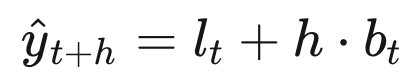

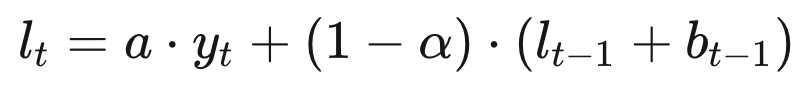

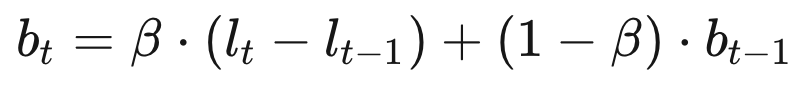

In the above equations, α and β are constants which can be configured. The values lt and bt represent the level and trend values repsectively. The trend value is the slope of the linear forecast function and the level value is the y-intercept of the linear forecast function. The slope and y-intercept values are continuously updated using the second and third update equations. Finally, the slope and y-intercept are used to calculate the forecast yt+h (in equation 1), which is h time steps ahead of the current time step.

In [57]:
holt=Holt(np.asarray(model_train["confirmed"])).fit(smoothing_level=0.4, smoothing_slope=0.4,optimized=False)    

In [58]:
y_pred["Holt"]=holt.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["confirmed"],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["confirmed"],y_pred["Holt"])))
mape = np.mean(np.abs((y_pred["confirmed"].values - y_pred["Holt"])/y_pred["confirmed"].values))*100
print("MAPE: ",mape)

Root Mean Square Error Holt's Linear Model:  519623.58121840394
MAPE:  1.0712678265413076


In [59]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

**Holt's Linear Model performs the best among all the models that we have yet tried.**

In [60]:
holt_new_date=[]
holt_new_prediction=[]
for i in range(1,18):
    holt_new_date.append(datetime.now() + timedelta(days=i))
    holt_new_prediction.append(holt.forecast((len(valid)+i))[-1])

model_predictions["Holt's Linear Model Prediction"]=holt_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction
0,2021-05-01 13:46:17.665292,33540104.838220,53039798.274990,68097645.176028,44918639.341964
1,2021-05-02 13:46:17.666294,33636551.269467,53879527.195744,69001366.325381,45127921.614868
2,2021-05-03 13:46:17.666818,33732997.700713,54751606.358645,69915486.899866,45337203.887772
3,2021-05-04 13:46:17.667443,33829444.131959,55657065.654369,70840102.415714,45546486.160675
4,2021-05-05 13:46:17.667914,33925890.563206,56596956.122020,71775309.045620,45755768.433579


**Holts's Winter Model**

Holt-Winters is a model of time series behavior. Forecasting always requires a model, and Holt-Winters is a way to model three aspects of the time series: a typical value (average), a slope (trend) over time, and a cyclical repeating pattern (seasonality). Holt-Winters uses exponential smoothing to encode lots of values from the past and use them to predict “typical” values for the present and future.

Exponential smoothing assigns exponentially decreasing weights and values against historical data to decrease the value of the weight for the older data. In other words, more recent historical data is assigned more weight in forecasting than the older results.



In [61]:
model_train=datewise.iloc[:int(datewise.shape[0]*0.95)]
valid=datewise.iloc[int(datewise.shape[0]*0.95):]
y_pred=valid.copy()

In [62]:
es=ExponentialSmoothing(np.asarray(model_train['confirmed']),seasonal_periods=14,trend='add', seasonal='mul').fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [63]:
y_pred["Holt's Winter Model"]=es.forecast(len(valid))
model_scores.append(np.sqrt(mean_squared_error(y_pred["confirmed"],y_pred["Holt's Winter Model"])))
print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_pred["confirmed"],y_pred["Holt's Winter Model"])))
mape = np.mean(np.abs((y_pred["confirmed"].values - y_pred["Holt's Winter Model"])/y_pred["confirmed"].values))*100
print("MAPE: ",mape)

Root Mean Square Error for Holt's Winter Model:  379350.33287935524
MAPE:  0.7535840108735206


In [64]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=valid.index, y=y_pred["Holt\'s Winter Model"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Winter Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

**Holts Winter Model is giving the lowest error and we can safely assusme that this is the best model to be used for predicting no of COVID-19 cases**

**Predicting cases for the next few days**

In [65]:
holt_winter_new_prediction=[]
for i in range(1,18):
    holt_winter_new_prediction.append(es.forecast((len(valid)+i))[-1])
model_predictions["Holt's Winter Model Prediction"]=holt_winter_new_prediction
model_predictions.head()

,Dates,Linear Regression Prediction,Polynonmial Regression Prediction,SVM Prediction,Holt's Linear Model Prediction,Holt's Winter Model Prediction
0,2021-05-01 13:46:17.665292,33540104.838220,53039798.274990,68097645.176028,44918639.341964,44629511.141062
1,2021-05-02 13:46:17.666294,33636551.269467,53879527.195744,69001366.325381,45127921.614868,44828609.463316
2,2021-05-03 13:46:17.666818,33732997.700713,54751606.358645,69915486.899866,45337203.887772,45080049.887603
3,2021-05-04 13:46:17.667443,33829444.131959,55657065.654369,70840102.415714,45546486.160675,45325630.949037
4,2021-05-05 13:46:17.667914,33925890.563206,56596956.122020,71775309.045620,45755768.433579,45536485.648606
